In [1]:
import os
import shutil
import imagehash
import pandas as pd
from PIL import Image
from tqdm import tqdm

def image_directory_to_pandas(image_path):
    """
    Create a pandas DataFrame with image paths and taxonomic labels extracted from a directory structure.

    Parameters:
    ----------
    image_path : str
        The root directory containing subfolders with images.

    Returns:
    -------
    pandas.DataFrame
        A DataFrame containing image paths and label information. Columns include:
        - 'path': The full path to the image.
        - 'folder_label': The folder name, representing the original label (format: 'family_genus_species').
        - 'family': Extracted family name from the folder label.
        - 'genus': Extracted genus name from the folder label.
        - 'species': Combination of genus and species names (e.g., 'genus species').

    Raises:
    ------
    ValueError:
        If the folder label format does not match the expected 'family_genus_species' format.
    """
    labels = []
    paths = []

    # Walk through the directory and collect image paths and labels
    for root_dir, _, filenames in os.walk(image_path):
        for filename in filenames:
            # Ignore hidden files and non-image files
            if filename.startswith('.') or os.path.splitext(filename)[1].lower() not in {".jpeg", ".png", ".jpg"}:
                continue

            # Extract the folder name as the label, ignoring 'GT' directories
            folder_label = os.path.basename(root_dir)
            if folder_label != "GT":
                labels.append(folder_label)
                paths.append(os.path.join(root_dir, filename))

    # Create DataFrame with paths and folder labels
    df = pd.DataFrame({'image_path': paths, 'folder_label': labels})
    df['folder_label'] = df['folder_label'].astype("category")

    # Split the folder_label into 'family', 'genus', and 'species'
    try:
        df[['family', 'genus', 'species']] = df['folder_label'].str.split("_", expand=True)
        df['species'] = df['genus'] + " " + df['species']
    except ValueError as e:
        raise ValueError(
            "Error splitting folder labels. Ensure that your folder structure follows 'family_genus_species' format."
        ) from e

    # Return the dataframe with specified columns
    return df[['image_path', 'folder_label', 'family', 'genus', 'species']]


def copy_image_direcory(source_path, destination_path):
    """
    Copy images from a source directory to a destination directory while preserving 
    their subfolder structure, format, and size.

    Parameters:
    ----------
    source_path : str
        The path to the source directory containing subfolders with images.
    destination_path : str
        The path to the destination directory where images will be copied.
    """
    # Ensure the destination path exists
    os.makedirs(destination_path, exist_ok=True)

    # Walk through the source directory
    for root_dir, _, filenames in os.walk(source_path):
        for filename in filenames:
            # Skip hidden files and only process image files
            if filename.startswith('.') or os.path.splitext(filename)[1].lower() not in {".jpeg", ".png", ".jpg"}:
                continue

            # Full path of the source image
            source_image_path = os.path.join(root_dir, filename)
            
            # Create a relative path from the source directory to maintain the folder structure
            relative_path = os.path.relpath(root_dir, source_path)
            
            # Construct the corresponding destination directory path
            destination_dir = os.path.join(destination_path, relative_path)
            
            # Ensure the destination directory exists
            os.makedirs(destination_dir, exist_ok=True)
            
            # Copy the image to the destination directory
            destination_image_path = os.path.join(destination_dir, filename)
            shutil.copy2(source_image_path, destination_image_path)

            print(f"Copied {source_image_path} to {destination_image_path}")

    print("Image copy operation completed.")
    
    
def split_image_dataframe(df, test_size=0.2, val_size=0.1, random_state=42, stratify_by='folder_name'):
    """
    Split a pandas DataFrame into train, validation, and test sets,
    stratified by the 'folder_name' column.

    Args:
        df (pd.DataFrame): The DataFrame containing image paths and labels.
        test_size (float): Proportion of the dataset to include in the test split.
        val_size (float): Proportion of the dataset to include in the validation split.
        random_state (int): Seed for random number generation for reproducibility.

    Returns:
        tuple: Three pandas DataFrames for train, validation, and test sets.
    """
    # First, split into train+validation and test sets
    train_val_df, test_df = train_test_split(
        df,
        test_size=test_size,
        stratify=df[stratify_by],
        random_state=random_state
    )
    
    # Calculate the adjusted validation size relative to the remaining train+val data
    val_relative_size = val_size / (1 - test_size)
    
    # Split the train+validation set into train and validation sets
    train_df, val_df = train_test_split(
        train_val_df,
        test_size=val_relative_size,
        stratify=train_val_df[stratify_by],
        random_state=random_state
    )
    
    return train_df, val_df, test_df


def copy_dataset_images_to_directory(df, target_directory, path_column='image_path', label_column='folder_label'):
    """
    Copies images to a specified target directory while preserving 
    the subfolder structure based on a DataFrame's label column.
    Keeps original image format, size, and metadata intact.

    Parameters:
    ----------
    df : pandas.DataFrame
        A DataFrame containing the following columns:
        - 'path_column': The path to the source image (default: 'image_path').
        - 'label_column': The label to be used for creating subfolders (default: 'folder_label').
    target_directory : str
        The path to the target directory where images will be copied.
    path_column : str, optional
        The name of the column in the DataFrame that contains image paths.
        Default is 'image_path'.
    label_column : str, optional
        The name of the column in the DataFrame that contains the folder labels.
        Default is 'folder_label'.

    Returns:
    -------
    None
        Copies the images to the specified target directory while maintaining structure.
    """
    # Iterate through the DataFrame with a progress bar
    for _, row in tqdm(df.iterrows(), total=df.shape[0], desc="Copying images", unit="image"):
        image_path = row[path_column]
        label = row[label_column]
        
        # Create the subfolder in the target directory
        target_subfolder = os.path.join(target_directory, label)
        os.makedirs(target_subfolder, exist_ok=True)
        
        # Construct the target path for the image
        target_path = os.path.join(target_subfolder, os.path.basename(image_path))
        
        # Copy the image to the target directory, preserving metadata
        shutil.copy2(image_path, target_path)

    print(f"All images have been copied to {target_directory} with metadata preserved.")
    
    return True
    
    
def rename_and_convert_images(input_path, suffix):
    """
    Converts images to JPEG format (if necessary) and renames them according to the given pattern.
    
    Args:
    - input_path (str): Path to the main directory containing subfolders.
    - suffix (str): A suffix to add at the beginning of each renamed image.
    
    Example:
    If a subfolder is named "Family_Genus_species", the images inside it will be renamed to:
    "{suffix}_Genus_species_1.jpg", "{suffix}_Genus_species_2.jpg", etc.
    """
    # Iterate through each subfolder in the input path
    for subfolder in os.listdir(input_path):
        subfolder_path = os.path.join(input_path, subfolder)
        
        # Check if it's a directory
        if os.path.isdir(subfolder_path):
            # Extract genus and species from the subfolder name (assumes the format "Family_Genus_species")
            try:
                _, genus, species = subfolder.split('_')
            except ValueError:
                print(f"Skipping folder '{subfolder}': not in 'Family_Genus_species' format.")
                continue

            # Iterate through all files in the subfolder
            image_files = [f for f in os.listdir(subfolder_path) if f.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp', '.tiff'))]
            image_files.sort()  # Sort files to ensure consistent numbering

            # Rename each image with the desired pattern and convert if necessary
            for idx, image_name in enumerate(image_files, start=1):
                # Define the new image name with .jpeg extension
                new_image_name = f"{suffix}_{genus}_{species}_{idx}.jpeg"
                
                # Define the full paths for the old and new image names
                old_image_path = os.path.join(subfolder_path, image_name)
                new_image_path = os.path.join(subfolder_path, new_image_name)
                
                # Convert the image to .jpeg format if necessary
                try:
                    with Image.open(old_image_path) as img:
                        # Convert to RGB mode if the image has an alpha channel (like .png)
                        if img.mode in ("RGBA", "P"):
                            img = img.convert("RGB")
                        
                        # Save the image in .jpeg format with the new name
                        img.save(new_image_path, "JPEG", quality=95)
                        
                        # Optionally, remove the old file if it was converted
                        if old_image_path != new_image_path:
                            os.remove(old_image_path)
                    
                    print(f"Converted and renamed: {old_image_path} -> {new_image_path}")
                
                except Exception as e:
                    print(f"Error processing {old_image_path}: {e}")

    print("Renaming and conversion completed.")
    
    return True


def generate_image_hash(image_path):
    """
    Generate a perceptual hash for an image using the average hash method.

    Parameters:
    ----------
    image_path : str
        The file path of the image for which to generate the hash.

    Returns:
    -------
    ImageHash
        An average hash object for the provided image.
    """
    with Image.open(image_path) as img:
        return imagehash.average_hash(img)


def move_matching_images(target_images_folder, source_folder, destination_folder):
    """
    Detect and move duplicate images from the source folder to the destination folder
    based on matching image hashes in the target images folder.

    Parameters:
    ----------
    target_images_folder : str
        Path to the folder containing target images for comparison.
    source_folder : str
        Path to the folder containing source images to check for duplicates.
    destination_folder : str
        Path to the folder where duplicate images will be moved.

    Returns:
    -------
    None
        Moves duplicate images to the specified destination folder and prints the moved files.
    """
    # Ensure destination folder exists
    os.makedirs(destination_folder, exist_ok=True)
    
    # Generate hashes for target images
    target_hashes = {}
    for file_name in os.listdir(target_images_folder):
        # Process only image files, ignoring hidden files
        if file_name.lower().endswith(('jpg', 'jpeg', 'png')) and not file_name.startswith('.'):
            target_image_path = os.path.join(target_images_folder, file_name)
            target_hash = generate_image_hash(target_image_path)
            target_hashes[file_name] = target_hash

    # Compare and move matching images from source to destination
    for file_name in os.listdir(source_folder):
        # Process only image files, ignoring hidden files
        if file_name.lower().endswith(('jpg', 'jpeg', 'png')) and not file_name.startswith('.'):
            source_image_path = os.path.join(source_folder, file_name)
            source_hash = generate_image_hash(source_image_path)
            
            # Check for matching hashes
            for target_name, target_hash in target_hashes.items():
                if source_hash == target_hash:
                    destination_path = os.path.join(destination_folder, file_name)
                    shutil.move(source_image_path, destination_path)
                    print(f"Moved: {source_image_path} -> {destination_path}")
                    break
                
                

In [ ]:
from cryptovision.tools import image_directory_to_pandas

In [3]:
rename_and_convert_images('/Volumes/T7_shield/CryptoVision/Data/fish_functions/training/test', 'lab_')

Error processing /Volumes/T7_shield/CryptoVision/Data/fish_functions/training/test/Blenniidae_Ecsenius_bicolor/._LIRS18_014_B1_134_JMC_3614_Cirripectes_variolosus.jpeg: cannot identify image file '/Volumes/T7_shield/CryptoVision/Data/fish_functions/training/test/Blenniidae_Ecsenius_bicolor/._LIRS18_014_B1_134_JMC_3614_Cirripectes_variolosus.jpeg'
Error processing /Volumes/T7_shield/CryptoVision/Data/fish_functions/training/test/Blenniidae_Ecsenius_bicolor/._LIRS18_014_B1_135_JMC_3615_Cirripectes_variolosus.jpeg: cannot identify image file '/Volumes/T7_shield/CryptoVision/Data/fish_functions/training/test/Blenniidae_Ecsenius_bicolor/._LIRS18_014_B1_135_JMC_3615_Cirripectes_variolosus.jpeg'
Error processing /Volumes/T7_shield/CryptoVision/Data/fish_functions/training/test/Blenniidae_Ecsenius_bicolor/._LIRS18_014_B1_136_JMC_3616_Cirripectes_variolosus.jpeg: cannot identify image file '/Volumes/T7_shield/CryptoVision/Data/fish_functions/training/test/Blenniidae_Ecsenius_bicolor/._LIRS18_01

True

In [31]:
# Lab Image set
df_sjb = image_directory_to_pandas(
    "/Users/leonardo/Library/CloudStorage/Box-Box/CryptoVision/Data/sjb/species",
)

df_web = image_directory_to_pandas(
    "/Users/leonardo/Library/CloudStorage/Box-Box/CryptoVision/Data/web/species/train",
)

# Concatenate both dataframes
df_raw = pd.concat([df_sjb, df_web], ignore_index=True)

print(f'Original Dataset Shape: {df_raw.shape}')

# Set Train, Validation & Test dataframes
label_count = df_raw['folder_label'].value_counts()

valid_labels = label_count[label_count >= 50].index
filtered_df_raw = df_raw[df_raw['folder_label'].isin(valid_labels)]

print(f'Filtered Dataset Shape: {filtered_df_raw.shape}')
print(f'Number of Classes: {filtered_df_raw["folder_label"].nunique()}')

Original Dataset Shape: (9492, 5)
Filtered Dataset Shape: (9023, 5)
Number of Classes: 57


In [32]:
copy_dataset_images_to_directory(
    filtered_df_raw, 
    '/Users/leonardo/Documents/Projects/cryptovision/data/processed/cv_images_dataset',
    'image_path',
    'folder_label'
)

Copying images: 100%|██████████| 9023/9023 [00:04<00:00, 1970.34image/s]

All images have been copied to /Users/leonardo/Documents/Projects/cryptovision/data/processed/cv_images_dataset with metadata preserved.


In [28]:
train_ds, val_ds, test_ds = split_image_dataframe(df_raw, 0.2, 0.2, 1, 'folder_label')

print(train_ds.shape)
print(val_ds.shape)
print(test_ds.shape)

(5694, 5)
(1899, 5)
(1899, 5)


In [ ]:
# Create source dataset metadata
def source_metadata(path, version, description, date_created, previous_version):
    
    df = image_directory_to_pandas(path)
    
    sample_path = df['image_path'].iloc[0]
    
    metadata = {
        'version': version,
        'source': path,
        'description': description,
        'date_created': date_created,
        'previous_version': previous_version,
        'images': df.shape[0],
        'species': df['species'].nunique(),
        'genus': df['genus'].nunique(),
        'family': df['family'].nunique(),
        'format': sample_path.split('.')[-1].upper()
    }
    
    return metadata
    

In [2]:
from cryptovision.tools import image_directory_to_pandas

In [7]:
df = image_directory_to_pandas(
    '/Volumes/T7_shield/CryptoVision/Data/Images/Sources/INaturaList/Species/v250116/images'
)

print(df.shape)
print(df['folder_label'].nunique())
print(df['species'].nunique())
print(df['genus'].nunique())
print(df['family'].nunique())

(17060, 5)
163
163
74
26


In [5]:
sample_path.split('.')[-1].upper()

'JPEG'

In [10]:
from PIL import Image
import os

def find_small_images(base_path, min_width=384, min_height=384, image_extensions=(".jpg", ".jpeg", ".png")):
    """
    Search for images in all subdirectories of a given path that have dimensions below the specified size.

    Args:
        base_path (str): The base directory to search.
        min_width (int): Minimum allowed width for images. Default is 384.
        min_height (int): Minimum allowed height for images. Default is 384.
        image_extensions (tuple): Tuple of allowed image file extensions. Default is (".jpg", ".jpeg", ".png").

    Returns:
        list: A list of paths for images that have dimensions below the specified size.
    """
    small_images = []

    for root, _, files in os.walk(base_path):
        for file in files:
            if file.lower().endswith(image_extensions) and not file.startswith('.'):
                image_path = os.path.join(root, file)
                try:
                    with Image.open(image_path) as img:
                        width, height = img.size
                        if width < min_width or height < min_height:
                            small_images.append(image_path)
                except Exception as e:
                    print(f"Error processing {image_path}: {e}")

    return small_images

In [11]:
base_directory = "/Volumes/T7_shield/CryptoVision/Data/Images/Sources/INaturaList/Species/v250116/images"
small_images_list = find_small_images(base_directory, min_width=384, min_height=384)

# Print the results
print(f"Found {len(small_images_list)} images with dimensions below 384x384.")
for img_path in small_images_list:
    print(img_path)

Found 616 images with dimensions below 384x384.
/Volumes/T7_shield/CryptoVision/Data/Images/Sources/INaturaList/Species/v250116/images/Apogonidae_Apogon_binotatus/inatlist_Apogon_binotatus_00107.jpeg
/Volumes/T7_shield/CryptoVision/Data/Images/Sources/INaturaList/Species/v250116/images/Apogonidae_Apogon_binotatus/inatlist_Apogon_binotatus_00086.jpeg
/Volumes/T7_shield/CryptoVision/Data/Images/Sources/INaturaList/Species/v250116/images/Apogonidae_Apogon_binotatus/inatlist_Apogon_binotatus_00028.jpeg
/Volumes/T7_shield/CryptoVision/Data/Images/Sources/INaturaList/Species/v250116/images/Apogonidae_Apogon_binotatus/inatlist_Apogon_binotatus_00018.jpeg
/Volumes/T7_shield/CryptoVision/Data/Images/Sources/INaturaList/Species/v250116/images/Apogonidae_Apogon_binotatus/inatlist_Apogon_binotatus_00085.jpeg
/Volumes/T7_shield/CryptoVision/Data/Images/Sources/INaturaList/Species/v250116/images/Apogonidae_Apogon_binotatus/inatlist_Apogon_binotatus_00087.jpeg
/Volumes/T7_shield/CryptoVision/Data/Ima

In [13]:
import cv2

def find_blurry_images(base_path, threshold=100, image_extensions=(".jpg", ".jpeg", ".png")):
    blurry_images = []

    for root, _, files in os.walk(base_path):
        for file in files:
            if file.lower().endswith(image_extensions) and not file.startswith('.'):
                image_path = os.path.join(root, file)
                try:
                    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
                    laplacian_var = cv2.Laplacian(img, cv2.CV_64F).var()
                    if laplacian_var < threshold:  # Threshold for blur detection
                        blurry_images.append((image_path, laplacian_var))
                except Exception as e:
                    print(f"Error processing {image_path}: {e}")
    
    return blurry_images

base_directory = "/Volumes/T7_shield/CryptoVision/Data/Images/Sources/INaturaList/Species/v250116/images"
blurry_images_list = find_blurry_images(base_directory, threshold=100)

# Print the results
print(f"Found {len(blurry_images_list)} blurry images.")
for img_path, variance in blurry_images_list:
    print(f"Image: {img_path}, Variance: {variance}")

Found 5001 blurry images.
Image: /Volumes/T7_shield/CryptoVision/Data/Images/Sources/INaturaList/Species/v250116/images/Apogonidae_Apogon_binotatus/inatlist_Apogon_binotatus_00133.jpeg, Variance: 26.286242534618435
Image: /Volumes/T7_shield/CryptoVision/Data/Images/Sources/INaturaList/Species/v250116/images/Apogonidae_Apogon_binotatus/inatlist_Apogon_binotatus_00134.jpeg, Variance: 38.405852601731816
Image: /Volumes/T7_shield/CryptoVision/Data/Images/Sources/INaturaList/Species/v250116/images/Apogonidae_Apogon_binotatus/inatlist_Apogon_binotatus_00130.jpeg, Variance: 28.400157209565243
Image: /Volumes/T7_shield/CryptoVision/Data/Images/Sources/INaturaList/Species/v250116/images/Apogonidae_Apogon_binotatus/inatlist_Apogon_binotatus_00129.jpeg, Variance: 14.280107351453639
Image: /Volumes/T7_shield/CryptoVision/Data/Images/Sources/INaturaList/Species/v250116/images/Apogonidae_Apogon_binotatus/inatlist_Apogon_binotatus_00128.jpeg, Variance: 98.24854868297294
Image: /Volumes/T7_shield/Cryp

In [21]:
import pandas as pd

# Set sources

df_lab = image_directory_to_pandas(
    '/Volumes/T7_shield/CryptoVision/Data/Images/Sources/Lab/SJB/Processed/Species/v250106/images', 'lab'
)

df_lirs23 = image_directory_to_pandas(
    '/Volumes/T7_shield/CryptoVision/Data/Images/Sources/Lab/LIRS23/Processed/Species/v250115/images', 'lirs23'
)

df_scls = image_directory_to_pandas(
    '/Volumes/T7_shield/CryptoVision/Data/Images/Sources/Lab/SCLS/Processed/Species/v250115/images', 'scls'
)

df_cbc24 = image_directory_to_pandas(
    '/Volumes/T7_shield/CryptoVision/Data/Images/Sources/Lab/CBC24/Processed/Species/v250115/images', 'cbc24'
)

df_web = image_directory_to_pandas(
    '/Volumes/T7_shield/CryptoVision/Data/Images/Sources/Web/Species/v250117/images', 'web'
)

df_inat = image_directory_to_pandas(
    '/Volumes/T7_shield/CryptoVision/Data/Images/Sources/INaturaList/Species/v250116/images', 'inat'
)

# Concatenate all dataframes
df_raw = pd.concat([df_lab, df_lirs23, df_scls, df_cbc24, df_web, df_inat], ignore_index=True)

og_size = df_raw.shape[0]

val_count = df['species'].value_counts()

valid_labels = val_count[val_count >= 50].index

df_filtered = df_raw[df_raw['species'].isin(valid_labels)]

print(f'Original Dataset Shape: {df_raw.shape}')
print(f'Filtered Dataset Shape: {df_filtered.shape} > Reduced by {(df_filtered.shape[0] / og_size - 1) * 100:.2f}%')


Original Dataset Shape: (32023, 6)
Filtered Dataset Shape: (25324, 6) > Reduced by -20.92%


In [27]:
print(df_filtered['family'].nunique())
print(df_filtered['genus'].nunique())
print(df_filtered['species'].nunique())

19
57
98


In [26]:
import shutil
from tqdm import tqdm

new_dir = '/Volumes/T7_shield/CryptoVision/Data/Images/Datasets/v2.0.0/images'

for index, data in tqdm(df_filtered.iterrows(), total=df_filtered.shape[0], desc="Copying images", unit="image"):
    
    image_name = os.path.basename(data['image_path'])
    folder_name = data['folder_label']
    
    os.makedirs(os.path.join(new_dir, folder_name), exist_ok=True)
    
    new_image_path = os.path.join(new_dir, folder_name, image_name)
    
    shutil.copy2(data['image_path'], new_image_path)

25324it [02:39, 158.91it/s]


In [28]:
import os
import shutil
from PIL import Image
import imagehash

def find_and_move_duplicates(base_path, target_folder, image_extensions=(".jpg", ".jpeg", ".png")):
    """
    Find duplicate images in a directory and move them to a target folder.

    Args:
        base_path (str): The base directory to search for duplicate images.
        target_folder (str): The directory where duplicate images will be moved.
        image_extensions (tuple): Tuple of allowed image file extensions.

    Returns:
        list: A list of tuples containing duplicate image paths and their original counterparts.
    """
    if not os.path.exists(target_folder):
        os.makedirs(target_folder)

    hashes = {}
    duplicates = []

    for root, _, files in os.walk(base_path):
        for file in files:
            if file.lower().endswith(image_extensions) and not file.startswith('.'):
                image_path = os.path.join(root, file)
                try:
                    with Image.open(image_path) as img:
                        img_hash = imagehash.average_hash(img)
                        if img_hash in hashes:
                            duplicates.append((image_path, hashes[img_hash]))
                            # Move the duplicate image to the target folder
                            shutil.move(image_path, os.path.join(target_folder, os.path.basename(image_path)))
                        else:
                            hashes[img_hash] = image_path
                except Exception as e:
                    print(f"Error processing {image_path}: {e}")

    return duplicates

# Example usage
base_directory = "/Volumes/T7_shield/CryptoVision/Data/Images/Datasets/v2.0.0/images"
target_directory = "/Volumes/T7_shield/CryptoVision/Data/Images/Rejected/Duplicates_v2"


for folder in os.listdir(base_directory):
    
    if not os.path.isdir(os.path.join(base_directory, folder)):
        continue
    
    duplicates = find_and_move_duplicates(
        os.path.join(base_directory, folder), 
        os.path.join(target_directory, folder)
    )


Error processing /Volumes/T7_shield/CryptoVision/Data/Images/Datasets/v2.0.0/images/Chaenopsidae_Acanthemblemaria_aspera/._IMG_8989_Chaenopsidae.jpeg: cannot identify image file '/Volumes/T7_shield/CryptoVision/Data/Images/Datasets/v2.0.0/images/Chaenopsidae_Acanthemblemaria_aspera/._IMG_8989_Chaenopsidae.jpeg'
Error processing /Volumes/T7_shield/CryptoVision/Data/Images/Datasets/v2.0.0/images/Chaenopsidae_Acanthemblemaria_aspera/._IMG_8995_Chaenopsidae.jpeg: cannot identify image file '/Volumes/T7_shield/CryptoVision/Data/Images/Datasets/v2.0.0/images/Chaenopsidae_Acanthemblemaria_aspera/._IMG_8995_Chaenopsidae.jpeg'
Error processing /Volumes/T7_shield/CryptoVision/Data/Images/Datasets/v2.0.0/images/Chaenopsidae_Acanthemblemaria_aspera/._IMG_8998_Chaenopsidae.jpeg: cannot identify image file '/Volumes/T7_shield/CryptoVision/Data/Images/Datasets/v2.0.0/images/Chaenopsidae_Acanthemblemaria_aspera/._IMG_8998_Chaenopsidae.jpeg'
Error processing /Volumes/T7_shield/CryptoVision/Data/Images/

In [29]:
df_v2 = image_directory_to_pandas('/Volumes/T7_shield/CryptoVision/Data/Images/Datasets/v2.0.0/images')

df_v2.shape

(24415, 5)

In [30]:
df_v2['folder_label'].value_counts()

folder_label
Gobiidae_Nemateleotris_magnifica            888
Labridae_Pseudocheilinus_hexataenia         714
Tetraodontidae_Canthigaster_solandri        712
Gobiidae_Istigobius_decoratus               681
Chaetodontidae_Chaetodon_quadrimaculatus    645
                                           ... 
Apogonidae_Siphamia_tubifer                  67
Gobiidae_Priolepis_cincta                    66
Gobiidae_Eviota_prasina                      53
Gobiidae_Trimma_okinawae                     52
Pseudochromidae_Cypho_ purpurascens           3
Name: count, Length: 98, dtype: int64

In [1]:
from cryptovision.tools import image_directory_to_pandas


df = image_directory_to_pandas(
    '/Volumes/T7_shield/CryptoVision/Data/Images/Datasets/v2.0.0/images'
)

# 2) Create mappings for each taxonomic level
families = sorted(df['family'].unique())
family_to_idx = {f: i for i, f in enumerate(families)}

genera = sorted(df['genus'].unique())
genus_to_idx = {g: i for i, g in enumerate(genera)}

species = sorted(df['species'].unique())
species_to_idx = {s: i for i, s in enumerate(species)}

2025-01-28 11:36:38.893 | INFO     | cryptovision.config:<module>:15 - PROJ_ROOT path is: /Users/leonardo/Documents/Projects/cryptovision


In [3]:
import os
import pandas as pd
import tensorflow as tf


def process_image(image_path, family_label, genus_label, species_label):
    # Read the image
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    
    # Preprocess (resize, etc.)
    image = tf.image.resize(image, [224, 224])  # example
    image = image / 255.0  # scale to [0,1]
    
    # Convert labels to correct encoding
    family_idx = family_to_idx[family_label]
    genus_idx = genus_to_idx[genus_label]
    species_idx = species_to_idx[species_label]
    
    return image, (family_idx, genus_idx, species_idx)

In [5]:
df.head(10)

,image_path,folder_label,family,genus,species
0,/Volumes/T7_shield/CryptoVision/Data/Images/Da...,Apogonidae_Apogon_binotatus,Apogonidae,Apogon,Apogon binotatus
1,/Volumes/T7_shield/CryptoVision/Data/Images/Da...,Apogonidae_Apogon_binotatus,Apogonidae,Apogon,Apogon binotatus
2,/Volumes/T7_shield/CryptoVision/Data/Images/Da...,Apogonidae_Apogon_binotatus,Apogonidae,Apogon,Apogon binotatus
3,/Volumes/T7_shield/CryptoVision/Data/Images/Da...,Apogonidae_Apogon_binotatus,Apogonidae,Apogon,Apogon binotatus
4,/Volumes/T7_shield/CryptoVision/Data/Images/Da...,Apogonidae_Apogon_binotatus,Apogonidae,Apogon,Apogon binotatus
5,/Volumes/T7_shield/CryptoVision/Data/Images/Da...,Apogonidae_Apogon_binotatus,Apogonidae,Apogon,Apogon binotatus
6,/Volumes/T7_shield/CryptoVision/Data/Images/Da...,Apogonidae_Apogon_binotatus,Apogonidae,Apogon,Apogon binotatus
7,/Volumes/T7_shield/CryptoVision/Data/Images/Da...,Apogonidae_Apogon_binotatus,Apogonidae,Apogon,Apogon binotatus
8,/Volumes/T7_shield/CryptoVision/Data/Images/Da...,Apogonidae_Apogon_binotatus,Apogonidae,Apogon,Apogon binotatus
9,/Volumes/T7_shield/CryptoVision/Data/Images/Da...,Apogonidae_Apogon_binotatus,Apogonidae,Apogon,Apogon binotatus


In [6]:
# Create a list of tuples (image_path, family, genus, species)
data_tuples = list(df[['image_path','family','genus','species']].itertuples(index=False, name=None))

# Create a TensorFlow Dataset
dataset = tf.data.Dataset.from_tensor_slices(data_tuples)

dataset

<_TensorSliceDataset element_spec=TensorSpec(shape=(4,), dtype=tf.string, name=None)>

In [ ]:

dataset = dataset.map(lambda path, f, g, s: process_image(path, f, g, s),
                      num_parallel_calls=tf.data.AUTOTUNE)

# Shuffle, batch, prefetch for performance
dataset = dataset.shuffle(buffer_size=1000).batch(32).prefetch(tf.data.AUTOTUNE)


In [8]:
import cv2
import numpy as np

def measure_sharpness(image: np.ndarray) -> float:
    """
    Measures image sharpness using the variance of the Laplacian.
    Higher variance = sharper image.
    """
    laplacian = cv2.Laplacian(image, cv2.CV_64F)
    variance = laplacian.var()
    return variance


def measure_brightness(image: np.ndarray) -> float:
    """
    Measures average brightness of the image (grayscale).
    Range depends on pixel values (0-255 for 8-bit images).
    """
    return float(np.mean(image))


def measure_contrast(image: np.ndarray) -> float:
    """
    Measures contrast as the standard deviation of pixel intensities (grayscale).
    Higher std dev = higher contrast.
    """
    return float(np.std(image))


In [9]:
import os

# Example reference ranges (these should be tuned based on your dataset)
SHARPNESS_MIN, SHARPNESS_MAX = 0.0, 1000.0
BRIGHTNESS_MIN, BRIGHTNESS_MAX = 0.0, 255.0
CONTRAST_MIN, CONTRAST_MAX = 0.0, 128.0

def normalize(value, min_val, max_val):
    # Safely avoid divide-by-zero
    return max(0.0, min(1.0, (value - min_val) / float(max_val - min_val + 1e-8)))

def compute_quality_score(image_path: str,
                         w_sharp=0.5, w_bright=0.25, w_contrast=0.25) -> float:
    """
    Reads the image from 'image_path', computes heuristic metrics,
    and returns a single combined quality score between 0 and 1.
    """
    # 1) Read image and convert to grayscale
    img = cv2.imread(image_path, cv2.IMREAD_COLOR)
    if img is None:
        # If the image can't be read, return a low quality score or raise error
        return 0.0
    
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # 2) Compute heuristics
    sharpness = measure_sharpness(gray)
    brightness = measure_brightness(gray)
    contrast = measure_contrast(gray)
    
    # 3) Normalize metrics (0 to 1)
    norm_sharpness = normalize(sharpness, SHARPNESS_MIN, SHARPNESS_MAX)
    norm_brightness = normalize(brightness, BRIGHTNESS_MIN, BRIGHTNESS_MAX)
    norm_contrast = normalize(contrast, CONTRAST_MIN, CONTRAST_MAX)
    
    # 4) Weighted combination
    #  - Increase w_sharp if sharpness is more critical
    #  - Increase w_bright if correct exposure is more critical
    #  - Increase w_contrast if clarity of features is more critical
    combined_score = (w_sharp * norm_sharpness +
                      w_bright * norm_brightness +
                      w_contrast * norm_contrast)
    
    return combined_score

def evaluate_dataset(image_folder: str, threshold=0.5) -> None:
    """
    Goes through a folder of images, computes a quality score for each,
    and prints whether each image is above or below a threshold.
    """
    for filename in os.listdir(image_folder):
        if not filename.lower().endswith(('.jpg', '.jpeg', '.png')):
            continue  # skip non-image files
        
        image_path = os.path.join(image_folder, filename)
        score = compute_quality_score(image_path)
        
        decision = "GOOD" if score >= threshold else "POOR"
        print(f"{filename}: score={score:.3f} -> {decision}")


In [11]:
path = '/Volumes/T7_shield/CryptoVision/Data/Images/Datasets/v2.0.0/images/Chaenopsidae_Acanthemblemaria_aspera'

evaluate_dataset(path, threshold=0.2)

lab_Acanthemblemaria_aspera_0019.jpg: score=0.092 -> POOR
lab_Acanthemblemaria_aspera_0031.jpg: score=0.069 -> POOR
lab_Acanthemblemaria_aspera_0025.jpg: score=0.089 -> POOR
lab_Acanthemblemaria_aspera_0024.jpg: score=0.113 -> POOR
lab_Acanthemblemaria_aspera_0030.jpg: score=0.117 -> POOR
lab_Acanthemblemaria_aspera_0018.jpg: score=0.089 -> POOR
lab_Acanthemblemaria_aspera_0026.jpg: score=0.087 -> POOR
lab_Acanthemblemaria_aspera_0032.jpg: score=0.324 -> GOOD
lab_Acanthemblemaria_aspera_0033.jpg: score=0.356 -> GOOD
lab_Acanthemblemaria_aspera_0027.jpg: score=0.092 -> POOR
lab_Acanthemblemaria_aspera_0037.jpg: score=0.078 -> POOR
lab_Acanthemblemaria_aspera_0036.jpg: score=0.096 -> POOR
lab_Acanthemblemaria_aspera_0022.jpg: score=0.168 -> POOR
lab_Acanthemblemaria_aspera_0034.jpg: score=0.098 -> POOR
lab_Acanthemblemaria_aspera_0020.jpg: score=0.062 -> POOR
lab_Acanthemblemaria_aspera_0008.jpg: score=0.103 -> POOR
lab_Acanthemblemaria_aspera_0021.jpg: score=0.121 -> POOR
lab_Acanthembl

In [4]:
import pandas as pd
from cryptovision.tools import image_directory_to_pandas

df_lab = image_directory_to_pandas(
    '/Volumes/T7_shield/CryptoVision/Data/Images/Sources/Lab/SJB/Processed/Species/v250106'
)

df_inat_full = image_directory_to_pandas(
    '/Volumes/T7_shield/CryptoVision/Data/Images/Sources/INaturaList/Species/v250116/images'
)

df_inat_clean = image_directory_to_pandas(
    '/Volumes/T7_shield/CryptoVision/Data/Images/Sources/INaturaList/Species/v250128/images'
)

species_list = df_inat_clean['species'].unique()

df_full = pd.concat([df_lab, df_inat_full], ignore_index=True, axis=0)
df_clean = pd.concat([df_lab, df_inat_clean], ignore_index=True, axis=0)

df_full = df_full[df_full['species'].isin(species_list)]

In [5]:
df_full.shape

(2805, 5)

In [6]:
df_clean.shape

(8439, 5)

## DataCleaning Impact

In [1]:
import os
import pandas as pd
from cryptovision.tools import image_directory_to_pandas

df_inat = image_directory_to_pandas(
    '/Volumes/T7_shield/CryptoVision/Data/Images/Sources/INaturaList/Species/v250116/images'
)


df_inat_clean = image_directory_to_pandas(
    '/Volumes/T7_shield/CryptoVision/Data/Images/Sources/INaturaList/Species/v250128/images'
)

species_list = df_inat_clean['species'].unique()

df_inat = df_inat[df_inat['species'].isin(species_list)]

df_inat['species'].unique()

2025-02-02 12:00:42.365 | INFO     | cryptovision.config:<module>:15 - PROJ_ROOT path is: /Users/leonardo/Documents/Projects/cryptovision


array(['Apogon binotatus', 'Apogon maculatus',
       'Cheilodipterus quinquelineatus', 'Ostorhinchus angustatus',
       'Ostorhinchus compressus', 'Ostorhinchus cyanosoma',
       'Ostorhinchus nigrofasciatus', 'Pristiapogon exostigma',
       'Pristiapogon kallopterus', 'Taeniamia fucata',
       'Cirripectes variolosus', 'Crossosalarias macrospilus',
       'Ecsenius bicolor', 'Ecsenius stictus', 'Glyptoparus delicatulus',
       'Plagiotremus rhinorhynchus', 'Salarias alboguttatus',
       'Acanthemblemaria aspera', 'Acanthemblemaria spinosa',
       'Chaetodon citrinellus', 'Chaetodon quadrimaculatus',
       'Cirrhitichthys oxycephalus', 'Neocirrhites armatus',
       'Paracirrhites arcatus', 'Amblygobius phalaena',
       'Coryphopterus personatus', 'Eviota atriventris'], dtype=object)

In [7]:
print(f"Dataset Inat Size: {df_inat.shape[0]} | Fam: {df_inat['family'].nunique()} | Gen: {df_inat['genus'].nunique()} | Sp: {df_inat['species'].nunique()}")
print(f"Dataset Inat Clean Size: {df_inat_clean.shape[0]} | Fam: {df_inat_clean['family'].nunique()} | Gen: {df_inat_clean['genus'].nunique()} | Sp: {df_inat_clean['species'].nunique()}")

Dataset Inat Size: 4617 | Fam: 6 | Gen: 19 | Sp: 27
Dataset Inat Clean Size: 3741 | Fam: 6 | Gen: 19 | Sp: 27


In [1]:
import os
import pandas as pd
from loguru import logger
from cryptovision.tools import image_directory_to_pandas


df_lab = image_directory_to_pandas(
    '/Volumes/T7_shield/CryptoVision/Data/Images/Sources/Lab/SJB/Processed/Species/v241226.1/images', 'lab'
)

df_lirs23 = image_directory_to_pandas(
    '/Volumes/T7_shield/CryptoVision/Data/Images/Sources/Lab/LIRS23/Processed/Species/v250115/images', 'lirs23'
)

df_scls = image_directory_to_pandas(
    '/Volumes/T7_shield/CryptoVision/Data/Images/Sources/Lab/SCLS/Processed/Species/v250115/images', 'scls'
)

df_cbc24 = image_directory_to_pandas(
    '/Volumes/T7_shield/CryptoVision/Data/Images/Sources/Lab/CBC24/Processed/Species/v250115/images', 'cbc24'
)

df_web = image_directory_to_pandas(
    '/Volumes/T7_shield/CryptoVision/Data/Images/Sources/Web/Species/v240712/images', 'web'
)

df_inat = image_directory_to_pandas(
    '/Volumes/T7_shield/CryptoVision/Data/Images/Sources/INaturaList/Species/v250116/images', 'inat'
)

df = pd.concat([df_lab, df_lirs23, df_scls, df_cbc24, df_web, df_inat], ignore_index=True)

logger.info(f"Dataset Size: {df.shape[0]:,} | Fam: {df['family'].nunique():,} | Gen: {df['genus'].nunique():,} | Sp: {df['species'].nunique():,}")

2025-02-03 18:47:08.785 | INFO     | cryptovision.config:<module>:15 - PROJ_ROOT path is: /Users/leonardo/Documents/Projects/cryptovision


2025-02-03 18:47:09.699 | INFO     | __main__:<module>:33 - Dataset Size: 34,861 | Fam: 29 | Gen: 81 | Sp: 190


In [6]:
logger.info(f"Dataset unique species by sources: {df['source'].value_counts()}")

2025-02-03 18:48:46.427 | INFO     | __main__:<module>:1 - Dataset unique species by sources: source
inat      17020
web        8751
lab        7493
lirs23      877
cbc24       362
scls        358
Name: count, dtype: int64


In [2]:
df_v1 = image_directory_to_pandas(
    '/Volumes/T7_shield/CryptoVision/Data/Images/Datasets/v1.0.0/images'
)

def get_prefix(path):
    return os.path.basename(path)[:3]

df_v1['source'] = df_v1['image_path'].apply(get_prefix)

df_v1['source'].value_counts()

source
web    7023
sjb    1993
Name: count, dtype: int64

In [7]:
import pandas as pd
import hashlib

def flag_duplicate_images(df, image_path_column="image_path"):
    """
    Identifies duplicate images in a DataFrame and flags them as 'og' (original) or 'dub' (duplicate).

    Args:
    - df (pd.DataFrame): DataFrame containing image paths.
    - image_path_column (str): Column name in the DataFrame that contains image paths.

    Returns:
    - pd.DataFrame: DataFrame with an additional 'duplicate_flag' column.
    """

    # Ensure the DataFrame has the correct column
    if image_path_column not in df.columns:
        raise ValueError(f"Column '{image_path_column}' not found in DataFrame.")

    # Dictionary to store image hashes
    hashes = {}
    flags = []

    # Iterate through the DataFrame to check for duplicates
    for path in df[image_path_column]:
        file_hash = compute_file_hash(path)

        if file_hash in hashes:
            flags.append(True)  # Mark as duplicate
        else:
            hashes[file_hash] = path
            flags.append(False)  # Mark as original

    # Add the new flag column
    df["duplicate_flag"] = flags
    return df

def compute_file_hash(file_path, hash_func=hashlib.sha256):
    """
    Computes the hash of a file using the given hashing function.

    Args:
    - file_path (str): Path to the file.
    - hash_func (function): Hashing function from hashlib (default: sha256).

    Returns:
    - str: Hexadecimal hash of the file.
    """
    hasher = hash_func()
    try:
        with open(file_path, "rb") as f:
            while chunk := f.read(8192):
                hasher.update(chunk)
        return hasher.hexdigest()
    except FileNotFoundError:
        return None  # Handle missing files gracefully

from collections import defaultdict
import imagehash
from PIL import Image

def find_duplicate_images_with_flags(df, image_column):
    """
    Identify duplicate images in a pandas DataFrame based on perceptual hash (pHash) and flag them.

    Parameters:
    - df (pd.DataFrame): DataFrame containing image paths.
    - image_column (str): Name of the column in the DataFrame that contains image paths.

    Returns:
    - flagged_dict (dict): Dictionary where keys are image paths and values are True (duplicate) or False (kept).
    """
    hash_dict = defaultdict(list)

    # Compute pHash for each image and group by hash
    for image_path in df[image_column]:
        if not isinstance(image_path, str):
            continue  # Skip invalid paths

        try:
            img = Image.open(image_path)
            img_hash = imagehash.phash(img)
            hash_dict[str(img_hash)].append(image_path)
        except Exception as e:
            print(f"Error processing {image_path}: {e}")

    # Prepare the flagged dictionary
    flagged_dict = {}

    for hash_val, paths in hash_dict.items():
        if len(paths) > 1:
            # Keep the first image, mark others as duplicates
            flagged_dict[paths[0]] = False  # Kept
            for duplicate_path in paths[1:]:
                flagged_dict[duplicate_path] = True  # Duplicate
        else:
            flagged_dict[paths[0]] = False  # Unique, no duplicates

    return flagged_dict

from collections import defaultdict
import imagehash
from PIL import Image
from tqdm import tqdm

def find_duplicate_images_with_flags(df, image_column):
    """
    Identify duplicate images in a pandas DataFrame based on perceptual hash (pHash) and flag them.

    Parameters:
    - df (pd.DataFrame): DataFrame containing image paths.
    - image_column (str): Name of the column in the DataFrame that contains image paths.

    Returns:
    - flagged_dict (dict): Dictionary where keys are image paths and values are True (duplicate) or False (kept).
    """
    hash_dict = defaultdict(list)

    # Compute pHash for each image and group by hash with a progress bar
    for image_path in tqdm(df[image_column], desc="Processing Images", unit="image"):
        if not isinstance(image_path, str):
            continue  # Skip invalid paths

        try:
            img = Image.open(image_path)
            img_hash = imagehash.phash(img)
            hash_dict[str(img_hash)].append(image_path)
        except Exception as e:
            print(f"Error processing {image_path}: {e}")

    # Prepare the flagged dictionary
    flagged_dict = {}

    for hash_val, paths in tqdm(hash_dict.items(), desc="Flagging Duplicates", unit="hash"):
        if len(paths) > 1:
            # Keep the first image, mark others as duplicates
            flagged_dict[paths[0]] = False  # Kept
            for duplicate_path in paths[1:]:
                flagged_dict[duplicate_path] = True  # Duplicate
        else:
            flagged_dict[paths[0]] = False  # Unique, no duplicates

    return flagged_dict



In [8]:
duplicates = find_duplicate_images_with_flags(df, 'image_path')

df['duplicate_flag'] = df['image_path'].map(duplicates)

df['duplicate_flag'].value_counts()

Flagging Duplicates: 100%|██████████| 31851/31851 [00:00<00:00, 3563899.61hash/s]


duplicate_flag
False    31851
True      3010
Name: count, dtype: int64

In [10]:
# Filter by Non Duplicates
df_filterad = df[~df['duplicate_flag']]
logger.info(f"Dataset Filterad By Non Duplicates: {df_filterad.shape[0]:,} | Fam: {df_filterad['family'].nunique():,} | Gen: {df_filterad['genus'].nunique():,} | Sp: {df_filterad['species'].nunique():,}")

2025-02-03 19:00:34.991 | INFO     | __main__:<module>:3 - Dataset Filterad By Non Duplicates: 31,851 | Fam: 29 | Gen: 81 | Sp: 190


In [11]:
# Filter by Species >= 100
count_species = df_filterad['species'].value_counts()
df_final = df_filterad[df_filterad['species'].isin(count_species[count_species >= 90].index)]
logger.info(f"Dataset Filtered By Species >= 100: {df_final.shape[0]:,} | Fam: {df_final['family'].nunique():,} | Gen: {df_final['genus'].nunique():,} | Sp: {df_final['species'].nunique():,}")

2025-02-03 19:00:37.592 | INFO     | __main__:<module>:4 - Dataset Filtered By Species >= 100: 29,604 | Fam: 22 | Gen: 62 | Sp: 116


In [13]:
df_final['species'].value_counts()

species
Nemateleotris magnifica       905
Pseudocheilinus hexataenia    732
Canthigaster solandri         727
Istigobius decoratus          702
Chaetodon quadrimaculatus     646
                             ... 
Enneanectes atrorus            95
Scorpaenodes kelloggi          94
Enneanectes altivelis          92
Trimma lantana                 91
Ctenogobiops mitodes           90
Name: count, Length: 116, dtype: int64

In [18]:
df_final['source'].value_counts()

source
inat      14334
web        7555
lab        6664
lirs23      438
cbc24       362
scls        251
Name: count, dtype: int64

In [17]:
sp_list = df_final[df_final['source'] == 'inat']['folder_label'].unique()



for sp in sorted(sp_list):
    print(sp)

Apogonidae_Apogon_binotatus
Apogonidae_Apogon_maculatus
Apogonidae_Cheilodipterus_quinquelineatus
Apogonidae_Fowleria_vaiulae
Apogonidae_Ostorhinchus_angustatus
Apogonidae_Ostorhinchus_compressus
Apogonidae_Ostorhinchus_cyanosoma
Apogonidae_Ostorhinchus_nigrofasciatus
Apogonidae_Pristiapogon_exostigma
Apogonidae_Pristiapogon_kallopterus
Apogonidae_Taeniamia_fucata
Blenniidae_Cirripectes_variolosus
Blenniidae_Crossosalarias_macrospilus
Blenniidae_Ecsenius_bicolor
Blenniidae_Ecsenius_pulcher
Blenniidae_Ecsenius_stictus
Blenniidae_Enchelyurus_ater
Blenniidae_Glyptoparus_delicatulus
Blenniidae_Plagiotremus_rhinorhynchus
Blenniidae_Salarias_alboguttatus
Chaenopsidae_Acanthemblemaria_aspera
Chaenopsidae_Acanthemblemaria_spinosa
Chaetodontidae_Chaetodon_citrinellus
Chaetodontidae_Chaetodon_quadrimaculatus
Cirrhitidae_Cirrhitichthys_oxycephalus
Cirrhitidae_Neocirrhites_armatus
Cirrhitidae_Paracirrhites_arcatus
Creediidae_Limnichthys_nitidus
Gobiidae_Amblygobius_phalaena
Gobiidae_Coryphopterus_

In [32]:
import plotly.express as px

df_plot = df_filtered.groupby(['source',])['species'].count().reset_index()

fig = px.bar(df_plot, x='species', y='source', title='Number of Species per Source', color='source', orientation='h',)
fig.show()

In [34]:
df[df['duplicate_flag'] == True]['source'].value_counts()

source
web     352
inat    312
Name: count, dtype: int64

In [35]:
df[df['duplicate_flag'] == True].head(10)

,image_path,source,folder_label,family,genus,species,duplicate_flag
9161,/Volumes/T7_shield/CryptoVision/Data/Images/So...,web,Apogonidae_Apogon_binotatus,Apogonidae,Apogon,Apogon binotatus,True
9184,/Volumes/T7_shield/CryptoVision/Data/Images/So...,web,Apogonidae_Apogon_binotatus,Apogonidae,Apogon,Apogon binotatus,True
9186,/Volumes/T7_shield/CryptoVision/Data/Images/So...,web,Apogonidae_Apogon_binotatus,Apogonidae,Apogon,Apogon binotatus,True
9187,/Volumes/T7_shield/CryptoVision/Data/Images/So...,web,Apogonidae_Apogon_binotatus,Apogonidae,Apogon,Apogon binotatus,True
9191,/Volumes/T7_shield/CryptoVision/Data/Images/So...,web,Apogonidae_Apogon_binotatus,Apogonidae,Apogon,Apogon binotatus,True
9193,/Volumes/T7_shield/CryptoVision/Data/Images/So...,web,Apogonidae_Apogon_binotatus,Apogonidae,Apogon,Apogon binotatus,True
9195,/Volumes/T7_shield/CryptoVision/Data/Images/So...,web,Apogonidae_Apogon_binotatus,Apogonidae,Apogon,Apogon binotatus,True
9196,/Volumes/T7_shield/CryptoVision/Data/Images/So...,web,Apogonidae_Apogon_binotatus,Apogonidae,Apogon,Apogon binotatus,True
9198,/Volumes/T7_shield/CryptoVision/Data/Images/So...,web,Apogonidae_Apogon_binotatus,Apogonidae,Apogon,Apogon binotatus,True
9199,/Volumes/T7_shield/CryptoVision/Data/Images/So...,web,Apogonidae_Apogon_binotatus,Apogonidae,Apogon,Apogon binotatus,True


In [36]:
df_filterad['source'].value_counts()

source
inat      16708
web        8399
lab        7493
lirs23      877
cbc24       362
scls        358
Name: count, dtype: int64

In [14]:
import os
from PIL import Image
import imagehash
from collections import defaultdict
import pandas as pd

def find_duplicate_images_from_dataframe(df, image_column):
    """
    Identify duplicate images listed in a pandas DataFrame based on perceptual hash (pHash).

    Parameters:
    - df (pd.DataFrame): DataFrame containing image paths.
    - image_column (str): Name of the column in the DataFrame that contains image paths.

    Returns:
    - duplicates (dict): Dictionary where keys are unique hashes and values are lists of file paths with that hash.
    """
    hash_dict = defaultdict(list)

    # Iterate through the image paths in the DataFrame
    for image_path in df[image_column]:
        if not isinstance(image_path, str):
            continue  # Skip invalid paths

        try:
            # Calculate perceptual hash
            img = Image.open(image_path)
            img_hash = imagehash.phash(img)
            hash_dict[str(img_hash)].append(image_path)
        except Exception as e:
            print(f"Error processing {image_path}: {e}")

    # Identify duplicates (hashes with more than one file)
    duplicates = {hash_val: paths for hash_val, paths in hash_dict.items() if len(paths) > 1}
    return duplicates

def print_duplicates(duplicates):
    """
    Print duplicate images in a readable format.

    Parameters:
    - duplicates (dict): Dictionary of duplicate images returned by `find_duplicate_images_from_dataframe`.
    """
    for hash_val, paths in duplicates.items():
        print(f"Hash: {hash_val}")
        for path in paths:
            print(f"  {path}")
        print("\n")


In [ ]:
duplicates = find_duplicate_images_from_dataframe(df_web, 'image_path')

if duplicates:
    print(f"Found {len(duplicates)} sets of duplicate images:")
    print_duplicates(duplicates)
else:
    print("No duplicate images found.")

Found 19 sets of duplicate images:
Hash: c587b434183766e7
  /Volumes/T7_shield/CryptoVision/Data/Images/Sources/Web/Species/v240712/images/Apogonidae_Apogon_binotatus/web_Apogon_binotatus_0031.jpeg
  /Volumes/T7_shield/CryptoVision/Data/Images/Sources/Web/Species/v240712/images/Apogonidae_Apogon_binotatus/web_Apogon_binotatus_0115.jpeg
  /Volumes/T7_shield/CryptoVision/Data/Images/Sources/Web/Species/v240712/images/Apogonidae_Apogon_binotatus/web_Apogon_binotatus_0069.jpeg
  /Volumes/T7_shield/CryptoVision/Data/Images/Sources/Web/Species/v240712/images/Apogonidae_Apogon_binotatus/web_Apogon_binotatus_0105.jpeg


Hash: 8e68b3a3ce1c5327
  /Volumes/T7_shield/CryptoVision/Data/Images/Sources/Web/Species/v240712/images/Apogonidae_Apogon_binotatus/web_Apogon_binotatus_0007.jpeg
  /Volumes/T7_shield/CryptoVision/Data/Images/Sources/Web/Species/v240712/images/Apogonidae_Apogon_binotatus/web_Apogon_binotatus_0076.jpeg


Hash: 9b2c60e9de3ae491
  /Volumes/T7_shield/CryptoVision/Data/Images/Source

In [16]:
from collections import defaultdict
import imagehash
from PIL import Image

def find_duplicate_images_with_flags(df, image_column):
    """
    Identify duplicate images in a pandas DataFrame based on perceptual hash (pHash) and flag them.

    Parameters:
    - df (pd.DataFrame): DataFrame containing image paths.
    - image_column (str): Name of the column in the DataFrame that contains image paths.

    Returns:
    - flagged_dict (dict): Dictionary where keys are image paths and values are True (duplicate) or False (kept).
    """
    hash_dict = defaultdict(list)

    # Compute pHash for each image and group by hash
    for image_path in df[image_column]:
        if not isinstance(image_path, str):
            continue  # Skip invalid paths

        try:
            img = Image.open(image_path)
            img_hash = imagehash.phash(img)
            hash_dict[str(img_hash)].append(image_path)
        except Exception as e:
            print(f"Error processing {image_path}: {e}")

    # Prepare the flagged dictionary
    flagged_dict = {}

    for hash_val, paths in hash_dict.items():
        if len(paths) > 1:
            # Keep the first image, mark others as duplicates
            flagged_dict[paths[0]] = False  # Kept
            for duplicate_path in paths[1:]:
                flagged_dict[duplicate_path] = True  # Duplicate
        else:
            flagged_dict[paths[0]] = False  # Unique, no duplicates

    return flagged_dict


In [24]:
duplic = find_duplicate_images_with_flags(df_web, 'image_path')

duplic

{'/Volumes/T7_shield/CryptoVision/Data/Images/Sources/Web/Species/v240712/images/Apogonidae_Apogon_binotatus/web_Apogon_binotatus_0016.jpeg': False,
 '/Volumes/T7_shield/CryptoVision/Data/Images/Sources/Web/Species/v240712/images/Apogonidae_Apogon_binotatus/web_Apogon_binotatus_0030.jpeg': False,
 '/Volumes/T7_shield/CryptoVision/Data/Images/Sources/Web/Species/v240712/images/Apogonidae_Apogon_binotatus/web_Apogon_binotatus_0031.jpeg': False,
 '/Volumes/T7_shield/CryptoVision/Data/Images/Sources/Web/Species/v240712/images/Apogonidae_Apogon_binotatus/web_Apogon_binotatus_0115.jpeg': True,
 '/Volumes/T7_shield/CryptoVision/Data/Images/Sources/Web/Species/v240712/images/Apogonidae_Apogon_binotatus/web_Apogon_binotatus_0069.jpeg': True,
 '/Volumes/T7_shield/CryptoVision/Data/Images/Sources/Web/Species/v240712/images/Apogonidae_Apogon_binotatus/web_Apogon_binotatus_0105.jpeg': True,
 '/Volumes/T7_shield/CryptoVision/Data/Images/Sources/Web/Species/v240712/images/Apogonidae_Apogon_binotatus/

In [25]:
df_web['duplicated'] = list(duplic.values())

In [27]:
print(df_web[~df_web['duplicated']].shape)
print(df_web.shape)

(7774, 6)
(8751, 6)


In [37]:
(df_web[~df_web['duplicated']].shape[0] / df_web.shape[0]) * 100

88.83556165009713

In [30]:
df_web[df_web['species'] == 'Apogon binotatus']['duplicated'].value_counts()

duplicated
False    94
True     30
Name: count, dtype: int64

In [19]:
df_sample = image_directory_to_pandas(
    '/Users/leonardo/Pictures/duplicate_test'
)

duplic = find_duplicate_images_with_flags(df_sample, 'image_path')

duplic

Flagging Duplicates: 100%|██████████| 7/7 [00:00<00:00, 142524.89hash/s]


{'/Users/leonardo/Pictures/duplicate_test/Apogonidae_Apogon_binotatus/web_Apogon_binotatus_0005.jpeg': False,
 '/Users/leonardo/Pictures/duplicate_test/Apogonidae_Apogon_binotatus/web_Apogon_binotatus_0005 copy.jpeg': True,
 '/Users/leonardo/Pictures/duplicate_test/Apogonidae_Apogon_binotatus/web_Apogon_binotatus_0003 copy 4.jpeg': False,
 '/Users/leonardo/Pictures/duplicate_test/Apogonidae_Apogon_binotatus/web_Apogon_binotatus_0003.jpeg': True,
 '/Users/leonardo/Pictures/duplicate_test/Apogonidae_Apogon_binotatus/web_Apogon_binotatus_0003 copy 2.jpeg': True,
 '/Users/leonardo/Pictures/duplicate_test/Apogonidae_Apogon_binotatus/web_Apogon_binotatus_0003 copy 3.jpeg': True,
 '/Users/leonardo/Pictures/duplicate_test/Apogonidae_Apogon_binotatus/web_Apogon_binotatus_0003 copy.jpeg': True,
 '/Users/leonardo/Pictures/duplicate_test/Apogonidae_Apogon_binotatus/web_Apogon_binotatus_0004.jpeg': False,
 '/Users/leonardo/Pictures/duplicate_test/Apogonidae_Apogon_binotatus/web_Apogon_binotatus_000

In [25]:
df_sample['duplicated'] = df_sample['image_path'].map(duplic)

for path in list(df_sample[~df_sample['duplicated']]['image_path']):
    print(path)

/Users/leonardo/Pictures/duplicate_test/Apogonidae_Apogon_binotatus/web_Apogon_binotatus_0005.jpeg
/Users/leonardo/Pictures/duplicate_test/Apogonidae_Apogon_binotatus/web_Apogon_binotatus_0003 copy 4.jpeg
/Users/leonardo/Pictures/duplicate_test/Apogonidae_Apogon_binotatus/web_Apogon_binotatus_0004.jpeg
/Users/leonardo/Pictures/duplicate_test/Apogonidae_Apogon_binotatus/web_Apogon_binotatus_0001 copy.jpeg
/Users/leonardo/Pictures/duplicate_test/Apogonidae_Apogon_binotatus/web_Apogon_binotatus_0006 copy 3.jpeg
/Users/leonardo/Pictures/duplicate_test/Apogonidae_Apogon_binotatus/web_Apogon_binotatus_0002.jpeg
/Users/leonardo/Pictures/duplicate_test/Apogonidae_Apogon_binotatus/web_Apogon_binotatus_0007.jpeg


In [30]:
import os
from PIL import Image
import imagehash
from collections import defaultdict
import pandas as pd

def find_duplicate_images_from_dataframe(df, image_column):
    """
    Identify duplicate images listed in a pandas DataFrame based on perceptual hash (pHash).

    Parameters:
    - df (pd.DataFrame): DataFrame containing image paths.
    - image_column (str): Name of the column in the DataFrame that contains image paths.

    Returns:
    - duplicates (dict): Dictionary where keys are unique hashes and values are lists of file paths with that hash.
    """
    hash_dict = defaultdict(list)

    # Iterate through the image paths in the DataFrame
    for image_path in df[image_column]:
        if not isinstance(image_path, str):
            continue  # Skip invalid paths

        try:
            # Calculate perceptual hash
            img = Image.open(image_path)
            img_hash = imagehash.phash(img)
            hash_dict[str(img_hash)].append(image_path)
        except Exception as e:
            print(f"Error processing {image_path}: {e}")

    # Identify duplicates (hashes with more than one file)
    duplicates = {hash_val: paths for hash_val, paths in hash_dict.items() if len(paths) > 1}
    return duplicates

def print_duplicates(duplicates):
    """
    Print duplicate images in a readable format.

    Parameters:
    - duplicates (dict): Dictionary of duplicate images returned by `find_duplicate_images_from_dataframe`.
    """
    for hash_val, paths in duplicates.items():
        print(f"Hash: {hash_val}")
        for path in paths:
            print(f"  {path}")
        print("\n")


duplicates = find_duplicate_images_from_dataframe(df_lab, 'image_path')

if duplicates:
    print(f"Found {len(duplicates)} sets of duplicate images:")
    print_duplicates(duplicates)
else:
    print("No duplicate images found.")

Found 279 sets of duplicate images:
Hash: c03f3fc0c02f6df0
  /Volumes/T7_shield/CryptoVision/Data/Images/Sources/Lab/SJB/Processed/Species/v241226.1/images/Apogonidae_Cheilodipterus_quinquelineatus/lab_Cheilodipterus_quinquelineatus_0021.jpeg
  /Volumes/T7_shield/CryptoVision/Data/Images/Sources/Lab/SJB/Processed/Species/v241226.1/images/Apogonidae_Cheilodipterus_quinquelineatus/lab_Cheilodipterus_quinquelineatus_0008.jpeg


Hash: c0c83f37c0f04fc7
  /Volumes/T7_shield/CryptoVision/Data/Images/Sources/Lab/SJB/Processed/Species/v241226.1/images/Apogonidae_Fowleria_vaiulae/lab_Fowleria_vaiulae_0031.jpeg
  /Volumes/T7_shield/CryptoVision/Data/Images/Sources/Lab/SJB/Processed/Species/v241226.1/images/Apogonidae_Fowleria_vaiulae/lab_Fowleria_vaiulae_0032.jpeg


Hash: c0c03f1ff0f0cfc1
  /Volumes/T7_shield/CryptoVision/Data/Images/Sources/Lab/SJB/Processed/Species/v241226.1/images/Apogonidae_Fowleria_vaiulae/lab_Fowleria_vaiulae_0001.jpeg
  /Volumes/T7_shield/CryptoVision/Data/Images/Sources/L

In [35]:
tot = 0

for hash_val, paths in duplicates.items():
    
    if len(paths) > 1:
        tot += len(paths) - 1
print(tot)

329


In [37]:
img_path = '/Users/leonardo/Pictures/fish_id_images/Aioliops megastigma.jpeg'

img = Image.open(img_path)
img_hash = imagehash.phash(img)

str(img_hash)

'86933caf5155136d'

In [38]:
def get_image_hash(image_path):
    
    img = Image.open(image_path)
    img_hash = imagehash.phash(img)
    
    return str(img_hash)

df_lab['hash'] = df_lab['image_path'].map(get_image_hash)

In [39]:
df_lab.shape[0]

7493

In [40]:
df_lab.drop_duplicates(subset=['hash'], keep='first').shape[0]

7164

In [42]:
df_lab.head(10)

,image_path,source,folder_label,family,genus,species,hash
0,/Volumes/T7_shield/CryptoVision/Data/Images/So...,lab,Apogonidae_Apogon_binotatus,Apogonidae,Apogon,Apogon binotatus,c0cc3f3fc0e80f87
1,/Volumes/T7_shield/CryptoVision/Data/Images/So...,lab,Apogonidae_Apogon_binotatus,Apogonidae,Apogon,Apogon binotatus,feb0c0ca3f34b069
2,/Volumes/T7_shield/CryptoVision/Data/Images/So...,lab,Apogonidae_Apogon_binotatus,Apogonidae,Apogon,Apogon binotatus,c03e3b7cc03f2f48
3,/Volumes/T7_shield/CryptoVision/Data/Images/So...,lab,Apogonidae_Apogon_binotatus,Apogonidae,Apogon,Apogon binotatus,c4c83f37c0f00f4f
4,/Volumes/T7_shield/CryptoVision/Data/Images/So...,lab,Apogonidae_Apogon_binotatus,Apogonidae,Apogon,Apogon binotatus,b590c0e93ff6c0a9
5,/Volumes/T7_shield/CryptoVision/Data/Images/So...,lab,Apogonidae_Apogon_binotatus,Apogonidae,Apogon,Apogon binotatus,8e08f7314f9866b3
6,/Volumes/T7_shield/CryptoVision/Data/Images/So...,lab,Apogonidae_Apogon_binotatus,Apogonidae,Apogon,Apogon binotatus,ffb4c0c06d3e1632
7,/Volumes/T7_shield/CryptoVision/Data/Images/So...,lab,Apogonidae_Apogon_binotatus,Apogonidae,Apogon,Apogon binotatus,bdc1c0ae3fc0d02f
8,/Volumes/T7_shield/CryptoVision/Data/Images/So...,lab,Apogonidae_Apogon_binotatus,Apogonidae,Apogon,Apogon binotatus,bf58c0e43f93d064
9,/Volumes/T7_shield/CryptoVision/Data/Images/So...,lab,Apogonidae_Apogon_binotatus,Apogonidae,Apogon,Apogon binotatus,c449bf3fd040f80f


In [43]:
df_web = image_directory_to_pandas(
    '/Volumes/T7_shield/CryptoVision/Data/Images/Sources/Web/Species/v240712/images'
)

df_web['hash'] = df_web['image_path'].map(get_image_hash)

In [44]:
df_web.drop_duplicates(subset=['hash'], keep='first').shape[0]

7774

In [45]:
df_web.shape[0]

8751

In [ ]:
# Load wab + INaturalist data

# Concatenate

# Apply get_hash

# Remove duplicates

# Count and compare sizes df_web vs df_concated vs foldersize

In [72]:
# Function to search in all subdirectories of a given path and cound the number of images

def count_images(directory):
    count = 0
    for root, _, files in os.walk(directory):
        count += len(files)
    return count

In [73]:
count_images('/Volumes/T7_shield/CryptoVision/Data/Images/Sources/Web/Species/v250117')

6581

In [64]:
df_web = image_directory_to_pandas(
    '/Volumes/T7_shield/CryptoVision/Data/Images/Sources/Web/Species/v250117/images'
)

df_web.shape[0]

6504

In [2]:
from pathlib import Path
from cryptovision.tools import image_directory_to_pandas

def get_image_hash(image_path):
    img = Image.open(image_path)
    img_hash = imagehash.phash(img)
    return str(img_hash)

def dataset_pipeline(path: Path, source: str):
    
    df = image_directory_to_pandas(path, source)
    
    df['hash'] = df['image_path'].map(get_image_hash)
    
    

2025-02-04 10:35:41.554 | INFO     | cryptovision.config:<module>:15 - PROJ_ROOT path is: /Users/leonardo/Documents/Projects/cryptovision


In [88]:
from pathlib import Path
from PIL import Image, ImageStat, ExifTags
import imagehash
import numpy as np
import cv2
from concurrent.futures import ThreadPoolExecutor
import pandas as pd
from cryptovision.tools import image_directory_to_pandas
import math

class ImageAttributes:
    
    def __init__(self, image_path):
        self.image_path = Path(image_path)  # Ensure it's a Path object
        self.img = Image.open(self.image_path)
        
        # Basic Attributes
        self.hash = str(imagehash.phash(self.img))  # Perceptual hash
        self.width, self.height = self.img.size  # Dimensions
        self.aspect_ratio = round(self.width / self.height, 2)  # Aspect ratio
        self.format = self.img.format  # Image format (JPG, PNG, etc.)
        self.mode = self.img.mode  # Color mode (RGB, Grayscale, etc.)
        self.file_size = self.image_path.stat().st_size  # File size in bytes

        # Image Quality & Color Analysis
        self.mean_brightness = self.calculate_mean_brightness()
        self.contrast = self.calculate_contrast()
        self.entropy = self.img.entropy()  # Image entropy (higher = more detail)
        self.blur_score = self.calculate_blur()  # Laplacian blur detection
        self.color_histogram = self.calculate_color_histogram()
        self.dominant_color = self.calculate_dominant_color()

        # Metadata Extraction
        self.metadata = self.extract_exif_metadata()

    def calculate_mean_brightness(self):
        """Calculate the mean pixel brightness."""
        stat = ImageStat.Stat(self.img)
        return round(sum(stat.mean) / len(stat.mean), 2)

    def calculate_contrast(self):
        """Calculate the contrast of the image using pixel standard deviation."""
        try:
            stat = ImageStat.Stat(self.img)
            variance = [max(v, 0) for v in stat.var]  # Ensure non-negative values
            return round(sum(math.sqrt(v) for v in variance) / len(variance), 2)
        except Exception as e:
            print(f"Error calculating contrast for {self.image_path}: {e}")
            return None  # Return None if contrast calculation fails

    def calculate_blur(self):
        """Estimate blur using variance of Laplacian."""
        img_cv = cv2.imread(str(self.image_path), cv2.IMREAD_GRAYSCALE)
        return round(cv2.Laplacian(img_cv, cv2.CV_64F).var(), 2) if img_cv is not None else None

    def calculate_color_histogram(self):
        """Compute a simple RGB histogram to detect grayscale images."""
        hist = self.img.histogram()
        return {
            "R": sum(hist[0:256]), 
            "G": sum(hist[256:512]), 
            "B": sum(hist[512:768])
        }

    def calculate_dominant_color(self):
        """Compute the dominant color in the image."""
        # Ensure image is in RGB mode
        img = self.img.convert("RGB")
        
        # Convert image to NumPy array
        img_array = np.array(img)
        
        # Ensure it has 3 channels (RGB)
        if len(img_array.shape) == 2:  # Grayscale image, convert to RGB
            img_array = np.stack([img_array] * 3, axis=-1)
        
        # Reshape to a list of pixels and compute the mean color
        pixels = img_array.reshape(-1, 3)
        dominant_color = np.mean(pixels, axis=0)
        
        return tuple(map(int, dominant_color))  # Convert to (R, G, B) format

    def extract_exif_metadata(self):
        """Extracts EXIF metadata if available."""
        try:
            exif_data = self.img._getexif()
            if exif_data:
                return {ExifTags.TAGS.get(tag, tag): value for tag, value in exif_data.items()}
        except AttributeError:
            return {}
        return {}

    def to_dict(self, min_size):
        """
        Convert image attributes to a dictionary.
        Adds `flag_small` to indicate if the image is smaller than `min_size`.
        """
        return {
            "image_path": str(self.image_path),
            "hash": self.hash,
            "width": self.width,
            "height": self.height,
            "aspect_ratio": self.aspect_ratio,
            "format": self.format,
            "mode": self.mode,
            "file_size": self.file_size,
            "brightness": self.mean_brightness,
            "contrast": self.contrast,
            "entropy": self.entropy,
            "blur_score": self.blur_score,
            "dominant_color": self.dominant_color,
            "flag_small": self.width < min_size and self.height < min_size
        }

    def __repr__(self):
        return (
            f"Image: {self.image_path}, Format: {self.format}, Mode: {self.mode}, "
            f"Size: {self.width}x{self.height}, Aspect Ratio: {self.aspect_ratio}, "
            f"Brightness: {self.mean_brightness}, Contrast: {self.contrast}, "
            f"Entropy: {self.entropy}, Blur Score: {self.blur_score}, "
            f"Dominant Color: {self.dominant_color}"
        )


In [16]:
from pathlib import Path
from concurrent.futures import ThreadPoolExecutor
import pandas as pd
from cryptovision.tools import image_directory_to_pandas

def process_image(image_path, min_size):
    """
    Process an image and return a dictionary of extracted attributes.
    """
    try:
        img_attr = ImageAttributes(image_path)
        return {
            "image_path": image_path,
            "hash": img_attr.hash,
            "width": img_attr.width,
            "height": img_attr.height,
            "aspect_ratio": img_attr.aspect_ratio,
            "format": img_attr.format,
            "mode": img_attr.mode,
            "file_size": img_attr.file_size,
            "brightness": img_attr.mean_brightness,
            "contrast": img_attr.contrast,
            "entropy": img_attr.entropy,
            "blur_score": img_attr.blur_score,
            "dominant_color": img_attr.dominant_color,
            "flag_small": img_attr.width < min_size or img_attr.height < min_size
        }
    except Exception as e:
        print(f"Error processing {image_path}: {e}")
        return None  # Return None if there's an issue

def build_dataset(path: Path, source: str, min_size: int):
    """
    Build dataset by extracting image attributes in parallel.
    """
    # Get initial DataFrame
    df = image_directory_to_pandas(path, source)
    
    # Process images in parallel
    with ThreadPoolExecutor() as executor:
        results = list(executor.map(lambda img: process_image(img, min_size), df["image_path"]))

    # Remove failed results (None values)
    results = [res for res in results if res is not None]

    # Convert list of dicts to a DataFrame
    df = pd.DataFrame.from_records(results)

    return df


In [13]:
df_v1 = build_dataset(
    '/Volumes/T7_shield/CryptoVision/Data/Images/Sources/Web/Species/v240712/images',
    'webV1',
    384
)

In [89]:
def build_dataset(path: Path, source: str, min_size: int, num_workers: int = None):
    """
    Build dataset by extracting image attributes in parallel.
    """
    # Get initial DataFrame
    df = image_directory_to_pandas(path, source)
    
    # Process images in parallel
    with ThreadPoolExecutor(max_workers=num_workers) as executor:
        results = list(executor.map(lambda img: ImageAttributes(img).to_dict(min_size), df["image_path"]))

    # Remove failed results (None values)
    results = [res for res in results if res is not None]

    # Convert results to DataFrame
    df_attributes = pd.DataFrame.from_records(results)

    # Merge attributes back with the original metadata
    df = df.merge(df_attributes, on="image_path", how="left")
    
    # Flag duplicates
    df['duplicates'] = df.duplicated(subset='hash', keep='first')
    
    # Round entropy to 5 digits
    df['entropy'] = df['entropy'].round(5)

    return df


In [98]:
df = build_dataset(
    '/Volumes/T7_shield/CryptoVision/Data/Images/Sources/Lab/SJB/Processed/Species/v241226.1/images',
    'sjb',
    384
)

In [109]:
df.head(5)

,image_path,source,folder_label,family,genus,species,hash,width,height,aspect_ratio,...,mode,file_size,brightness,contrast,entropy,blur_score,dominant_color,flag_small,duplicates,background_color
0,/Volumes/T7_shield/CryptoVision/Data/Images/So...,sjb,Apogonidae_Apogon_binotatus,Apogonidae,Apogon,Apogon binotatus,c0cc3f3fc0e80f87,4288,2848,1.51,...,RGB,762101,23.45,37.39,6.45205,32.26,"(33, 18, 18)",False,False,black
1,/Volumes/T7_shield/CryptoVision/Data/Images/So...,sjb,Apogonidae_Apogon_binotatus,Apogonidae,Apogon,Apogon binotatus,feb0c0ca3f34b069,4288,2848,1.51,...,RGB,786988,190.42,58.88,8.36385,38.03,"(203, 187, 180)",False,False,white
2,/Volumes/T7_shield/CryptoVision/Data/Images/So...,sjb,Apogonidae_Apogon_binotatus,Apogonidae,Apogon,Apogon binotatus,c03e3b7cc03f2f48,4288,2848,1.51,...,RGB,739710,27.35,45.44,6.60201,31.35,"(33, 26, 22)",False,False,black
3,/Volumes/T7_shield/CryptoVision/Data/Images/So...,sjb,Apogonidae_Apogon_binotatus,Apogonidae,Apogon,Apogon binotatus,c4c83f37c0f00f4f,4288,2848,1.51,...,RGB,950312,36.47,49.88,7.22632,48.99,"(48, 31, 29)",False,False,black
4,/Volumes/T7_shield/CryptoVision/Data/Images/So...,sjb,Apogonidae_Apogon_binotatus,Apogonidae,Apogon,Apogon binotatus,b590c0e93ff6c0a9,4288,2848,1.51,...,RGB,796139,195.03,51.93,8.21723,38.42,"(194, 199, 191)",False,False,white


In [120]:
def detect_background_color(brightness):
    
    if brightness < 50:
        return 'black'
    elif brightness > 150:
        return 'white'
    else:
        return 'mixed'
    
    
df['background_color'] = df['brightness'].apply(detect_background_color)

In [121]:
df['background_color'].value_counts()

background_color
black    4305
white    2681
mixed     507
Name: count, dtype: int64

In [125]:
lst = df[df['duplicates']].sample(10)['image_path'].tolist()

for i in lst:
    print(i)

/Volumes/T7_shield/CryptoVision/Data/Images/Sources/Lab/SJB/Processed/Species/v241226.1/images/Scorpaenidae_Caracanthus_maculatus/lab_Caracanthus_maculatus_0033.jpeg
/Volumes/T7_shield/CryptoVision/Data/Images/Sources/Lab/SJB/Processed/Species/v241226.1/images/Pseudochromidae_Cypho_purpurascens/lab_Cypho_purpurascens_0161.jpeg
/Volumes/T7_shield/CryptoVision/Data/Images/Sources/Lab/SJB/Processed/Species/v241226.1/images/Gobiidae_Trimma_eviotops/lab_Trimma_eviotops_0069.jpeg
/Volumes/T7_shield/CryptoVision/Data/Images/Sources/Lab/SJB/Processed/Species/v241226.1/images/Gobiidae_Paragobiodon_lacunicolus/lab_Paragobiodon_lacunicolus_0015.jpeg
/Volumes/T7_shield/CryptoVision/Data/Images/Sources/Lab/SJB/Processed/Species/v241226.1/images/Gobiidae_Trimma_macrophthalmus/lab_Trimma_macrophthalmus_0146.jpeg
/Volumes/T7_shield/CryptoVision/Data/Images/Sources/Lab/SJB/Processed/Species/v241226.1/images/Blenniidae_Ecsenius_pulcher/lab_Ecsenius_pulcher_0029.jpeg
/Volumes/T7_shield/CryptoVision/Data/

In [122]:
lst = df[df['background_color'] == 'mixed'].sample(10)['image_path'].tolist()

for i in lst:
    print(i)

/Volumes/T7_shield/CryptoVision/Data/Images/Sources/Lab/SJB/Processed/Species/v241226.1/images/Tripterygiidae_Enneanectes_altivelis/lab_Enneanectes_altivelis_0030.jpeg
/Volumes/T7_shield/CryptoVision/Data/Images/Sources/Lab/SJB/Processed/Species/v241226.1/images/Labridae_Pseudocheilinus_hexataenia/lab_Pseudocheilinus_hexataenia_0071.jpeg
/Volumes/T7_shield/CryptoVision/Data/Images/Sources/Lab/SJB/Processed/Species/v241226.1/images/Gobiidae_Coryphopterus_personatus/lab_Coryphopterus_personatus_0061.jpeg
/Volumes/T7_shield/CryptoVision/Data/Images/Sources/Lab/SJB/Processed/Species/v241226.1/images/Blenniidae_Ecsenius_stictus/lab_Ecsenius_stictus_0004.jpeg
/Volumes/T7_shield/CryptoVision/Data/Images/Sources/Lab/SJB/Processed/Species/v241226.1/images/Plesiopidae_Plesiops_coeruleolineatus/lab_Plesiops_coeruleolineatus_0019.jpeg
/Volumes/T7_shield/CryptoVision/Data/Images/Sources/Lab/SJB/Processed/Species/v241226.1/images/Pomacanthidae_Centropyge_bispinosa/lab_Centropyge_bispinosa_0013.jpeg


In [105]:
import os
os.cpu_count() // 2

5

In [102]:
df['duplicates'].value_counts()

duplicates
False    7164
True      329
Name: count, dtype: int64

In [103]:
df.to_csv('/Volumes/T7_shield/CryptoVision/Data/Images/Sources/Lab/SJB/Processed/Species/v241226.1/images_catalog.csv', index=False)

In [70]:
df_v1['source'] = 'web'

In [73]:
df_v1['duplicates'].value_counts()

duplicates
False    7774
True      977
Name: count, dtype: int64

<Axes: >

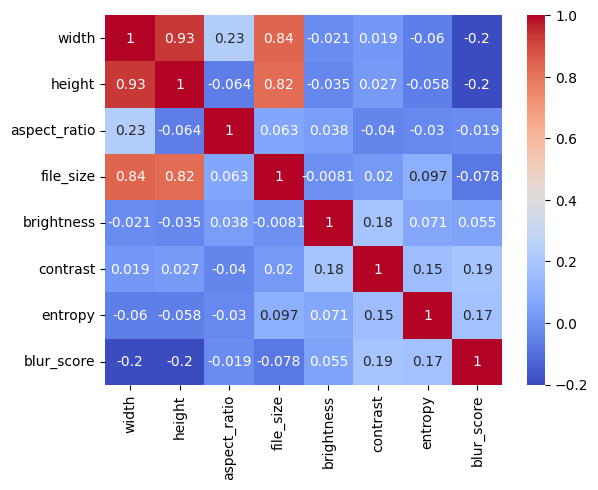

In [84]:
df_values = df_v1[['width', 'height', 'aspect_ratio', 'file_size', 'brightness', 'contrast', 'entropy', 'blur_score']]

df_values.corr()

import seaborn as sns

# Create a heatmap of the correlation matrix
sns.heatmap(df_values.corr(), annot=True, cmap='coolwarm')

In [77]:
df_v1.to_csv('/Volumes/T7_shield/CryptoVision/Data/Images/Sources/Web/Species/v240712/images_catalog.csv', index=False)

In [61]:
df_inat = build_dataset(
    '/Volumes/T7_shield/CryptoVision/Data/Images/Sources/INaturaList/Species/v250116/images',
    'inat',
    384
)

In [62]:
df_inat.head()

,image_path,source,folder_label,family,genus,species,hash,width,height,aspect_ratio,format,mode,file_size,brightness,contrast,entropy,blur_score,dominant_color,flag_small
0,/Volumes/T7_shield/CryptoVision/Data/Images/So...,inat,Gobiidae_Eviota_melasma,Gobiidae,Eviota,Eviota melasma,8e5c54f878e5096b,930,744,1.25,JPEG,RGB,742297,143.51,44.06,8.886323,324.74,"(150, 147, 132)",False
1,/Volumes/T7_shield/CryptoVision/Data/Images/So...,inat,Gobiidae_Eviota_melasma,Gobiidae,Eviota,Eviota melasma,8f66998657395c86,1315,841,1.56,JPEG,RGB,1053576,128.01,51.02,8.909495,353.57,"(160, 129, 93)",False
2,/Volumes/T7_shield/CryptoVision/Data/Images/So...,inat,Gobiidae_Eviota_melasma,Gobiidae,Eviota,Eviota melasma,e1e7376e38240c79,1893,1421,1.33,JPEG,RGB,2154758,147.30,47.56,9.115804,446.47,"(151, 155, 134)",False
3,/Volumes/T7_shield/CryptoVision/Data/Images/So...,inat,Gobiidae_Eviota_melasma,Gobiidae,Eviota,Eviota melasma,9f964821f2faa83c,1942,1627,1.19,JPEG,RGB,1408271,84.03,53.39,8.856227,78.71,"(57, 97, 97)",False
4,/Volumes/T7_shield/CryptoVision/Data/Images/So...,inat,Gobiidae_Eviota_melasma,Gobiidae,Eviota,Eviota melasma,c1ddbc52e80bb227,1349,970,1.39,JPEG,RGB,562741,121.73,46.19,9.089185,199.63,"(153, 127, 83)",False


In [63]:
df = pd.concat([df_inat, df_v1], ignore_index=True)

df['duplicates'] = df.duplicated(subset='hash', keep='first')

df.groupby('source')['duplicates'].value_counts()

source  duplicates
inat    False         34
webV1   False         46
        True          21
Name: count, dtype: int64

In [53]:
df[df['duplicates'] == True].head(25)

,image_path,source,folder_label,family,genus,species,hash,width,height,aspect_ratio,format,mode,file_size,brightness,contrast,entropy,blur_score,dominant_color,flag_small,duplicates
136,/Volumes/T7_shield/CryptoVision/Data/Images/So...,webV1,Apogonidae_Apogon_binotatus,Apogonidae,Apogon,Apogon binotatus,8e68b3a3ce1c5327,1024,550,1.86,JPEG,RGB,349507,78.99,43.16,8.561026,227.12,"(88, 89, 58)",False,True
140,/Volumes/T7_shield/CryptoVision/Data/Images/So...,webV1,Apogonidae_Apogon_binotatus,Apogonidae,Apogon,Apogon binotatus,9b2c60e9de3ae491,960,720,1.33,JPEG,RGB,475285,64.17,52.97,8.930316,316.41,"(67, 66, 58)",False,True
149,/Volumes/T7_shield/CryptoVision/Data/Images/So...,webV1,Apogonidae_Apogon_binotatus,Apogonidae,Apogon,Apogon binotatus,c587b434183766e7,2048,1595,1.28,JPEG,RGB,2209215,67.31,35.04,8.517772,122.14,"(75, 70, 55)",False,True
150,/Volumes/T7_shield/CryptoVision/Data/Images/So...,webV1,Apogonidae_Apogon_binotatus,Apogonidae,Apogon,Apogon binotatus,9b552d2f825226ed,2048,944,2.17,JPEG,RGB,959442,75.01,26.42,8.269024,74.10,"(81, 75, 68)",False,True
151,/Volumes/T7_shield/CryptoVision/Data/Images/So...,webV1,Apogonidae_Apogon_binotatus,Apogonidae,Apogon,Apogon binotatus,fe5333c14c84366b,378,272,1.39,JPEG,RGB,78368,125.84,56.87,9.334893,192.55,"(153, 116, 107)",True,True
152,/Volumes/T7_shield/CryptoVision/Data/Images/So...,webV1,Apogonidae_Apogon_binotatus,Apogonidae,Apogon,Apogon binotatus,b10f4f31cc61974d,500,375,1.33,JPEG,RGB,172644,134.54,35.31,8.717897,409.91,"(130, 136, 136)",True,True
153,/Volumes/T7_shield/CryptoVision/Data/Images/So...,webV1,Apogonidae_Apogon_binotatus,Apogonidae,Apogon,Apogon binotatus,df87e512c22f21d1,500,412,1.21,JPEG,RGB,80029,18.13,18.69,6.938405,5.63,"(30, 14, 9)",False,True
157,/Volumes/T7_shield/CryptoVision/Data/Images/So...,webV1,Apogonidae_Apogon_binotatus,Apogonidae,Apogon,Apogon binotatus,b02fea4b6c99d053,500,375,1.33,JPEG,RGB,134195,110.20,48.96,9.089432,467.71,"(122, 105, 102)",True,True
158,/Volumes/T7_shield/CryptoVision/Data/Images/So...,webV1,Apogonidae_Apogon_binotatus,Apogonidae,Apogon,Apogon binotatus,c77738e2c4946d89,500,375,1.33,JPEG,RGB,157409,61.62,44.87,8.754391,328.10,"(72, 59, 52)",True,True
161,/Volumes/T7_shield/CryptoVision/Data/Images/So...,webV1,Apogonidae_Apogon_binotatus,Apogonidae,Apogon,Apogon binotatus,894330759ddee34a,500,375,1.33,JPEG,RGB,130195,35.42,29.17,8.046083,160.34,"(45, 33, 27)",True,True


In [52]:
print(df_inat.shape[0])
print(df_v1.shape[0])

133
124


In [35]:
df_inat.drop_duplicates(subset="hash", keep="first")

(16708, 18)

In [37]:
# create a flag duplicate column for the dataframe using hash column - keeping with the first occurrence
df_inat['flag_duplicate'] = df_inat.duplicated(subset='hash', keep='first')

In [38]:
df_inat['flag_duplicate'].value_counts()


flag_duplicate
False    16708
True       312
Name: count, dtype: int64

In [36]:
17020 - 16708

312

In [29]:
df_inat_og = image_directory_to_pandas(
    '/Volumes/T7_shield/CryptoVision/Data/Images/Sources/INaturaList/Species/v250116/images'
)

df_inat_og.shape

(17020, 5)

In [18]:
df_v1.head(10)

,image_path,hash,width,height,aspect_ratio,format,mode,file_size,brightness,contrast,entropy,blur_score,dominant_color,flag_small
0,/Volumes/T7_shield/CryptoVision/Data/Images/So...,bb4a452ddb4225cd,640,351,1.82,JPEG,RGB,163155,113.03,34.18,8.579650,321.88,"(127, 112, 99)",True
1,/Volumes/T7_shield/CryptoVision/Data/Images/So...,c21a37c38b894dcf,225,225,1.00,JPEG,RGB,23841,88.32,43.39,8.735738,364.27,"(111, 89, 63)",True
2,/Volumes/T7_shield/CryptoVision/Data/Images/So...,c587b434183766e7,1024,798,1.28,JPEG,RGB,537558,67.31,34.88,8.503607,60.60,"(75, 70, 55)",False
3,/Volumes/T7_shield/CryptoVision/Data/Images/So...,8e68b3a3ce1c5327,1024,550,1.86,JPEG,RGB,349507,78.99,43.16,8.561026,227.12,"(88, 89, 58)",False
4,/Volumes/T7_shield/CryptoVision/Data/Images/So...,dc97c05e46e1d6c1,640,436,1.47,JPEG,RGB,123407,113.81,38.18,8.726764,427.17,"(144, 114, 82)",False
5,/Volumes/T7_shield/CryptoVision/Data/Images/So...,8b3b761ff85034c1,2160,1476,1.46,JPEG,RGB,2980590,135.41,60.08,9.288342,1868.14,"(139, 133, 132)",False
6,/Volumes/T7_shield/CryptoVision/Data/Images/So...,e7205809b2dcef55,800,600,1.33,JPEG,RGB,422335,101.68,53.49,9.266160,1018.71,"(117, 100, 86)",False
7,/Volumes/T7_shield/CryptoVision/Data/Images/So...,9b2c60e9de3ae491,960,720,1.33,JPEG,RGB,475285,64.17,52.97,8.930316,316.41,"(67, 66, 58)",False
8,/Volumes/T7_shield/CryptoVision/Data/Images/So...,bf3ec0c00f0f78b2,640,436,1.47,JPEG,RGB,53170,168.56,33.98,6.824630,226.59,"(177, 167, 159)",False
9,/Volumes/T7_shield/CryptoVision/Data/Images/So...,c59d3862ca97b43c,380,247,1.54,JPEG,RGB,52027,40.00,62.38,7.006313,515.89,"(46, 29, 43)",True


In [19]:
df_v1.shape

(8751, 14)

In [15]:
df_v1['image_attrs'].values[0]

Image: /Volumes/T7_shield/CryptoVision/Data/Images/Sources/Web/Species/v240712/images/Apogonidae_Apogon_binotatus/web_Apogon_binotatus_0016.jpeg, Format: JPEG, Mode: RGB, Size: 640x351, Aspect Ratio: 1.82, Brightness: 113.03, Contrast: 34.18, Entropy: 8.579650005608768, Blur Score: 321.88, Dominant Color: (127, 112, 99)

In [21]:
# Subset from df_v1 that weidth < 384 and height < 384

df_v1[(df_v1['width'] < 384) & (df_v1['height'] < 384)]


species
Labroides dimidiatus             135
Halichoeres claudia               75
Pseudocheilinus hexataenia        63
Koumansetta rainfordi             50
Nemateleotris magnifica           44
Gobiodon histrio                  40
Neocirrhites armatus              37
Centropyge flavissima             32
Chaetodon quadrimaculatus         28
Pomacentrus pavo                  27
Pomacanthus maculosus             27
Canthigaster solandri             24
Corythoichthys flavofasciatus     24
Apogon maculatus                  23
Priolepis semidoliatus            23
Aioliops megastigma               22
Istigobius decoratus              17
Chromis margaritifer              15
Eviota atriventris                14
Pseudocheilinus tetrataenia       13
Doryrhamphus excisus              13
Gobiodon quinquestrigatus         13
Apogon binotatus                  12
Enchelyurus ater                  12
Centropyge bispinosa              12
Fusigobius neophytus              11
Cypho purpurascens            

In [25]:
# Create column flag_small for images with width < 384 and height < 384
df_v1['flag_small'] = (df_v1['width'] < 384) & (df_v1['height'] < 384)

df_v1[~df_v1['flag_small']].shape

(7790, 10)

In [1]:
df_v1['flag_small'].value_counts()

NameError: name 'df_v1' is not defined

In [126]:
sp_list = [
    'Gobiidae_Eviota_sebreei'
    ,'Gobiidae_Eviota_teresae'
    ,'Gobiidae_Fusigobius_duospilus'
    ,'Gobiidae_Fusigobius_neophytus'
    ,'Gobiidae_Fusigobius_signipinnis'
    ,'Gobiidae_Gobiodon_histrio'
    ,'Gobiidae_Gobiodon_quinquestrigatus'
    ,'Gobiidae_Istigobius_decoratus'
    ,'Gobiidae_Istigobius_rigilius'
    ,'Gobiidae_Koumansetta_rainfordi'
    ,'Gobiidae_Nemateleotris_magnifica'
    ,'Gobiidae_Paragobiodon_lacunicolus'
    ,'Gobiidae_Paragobiodon_modestus'
    ,'Gobiidae_Pleurosicya_labiata'
    ,'Gobiidae_Priolepis_semidoliatus'
    ,'Gobiidae_Trimma_capostriatum'
    ,'Gobiidae_Trimma_lantana'
    ,'Gobiidae_Trimma_macrophthalmus'
    ,'Labridae_Coris_batuensis'
    ,'Labridae_Gomphosus_varius'
    ,'Labridae_Halichoeres_chloropterus'
    ,'Labridae_Halichoeres_claudia'
    ,'Labridae_Halichoeres_melanurus'
    ,'Labridae_Labroides_dimidiatus'
    ,'Labridae_Pseudocheilinus_hexataenia'
    ,'Labridae_Pseudocheilinus_tetrataenia'
    ,'Labridae_Thalassoma_amblycephalum'
    ,'Labridae_Thalassoma_lunare'
    ,'Monacanthidae_Monacanthus_tuckeri'
    ,'Pinguipedidae_Parapercis_cylindrica'
    ,'Plesiopidae_Plesiops_coeruleolineatus'
    ,'Pomacanthidae_Centropyge_bispinosa'
    ,'Pomacanthidae_Centropyge_flavissima'
    ,'Pomacanthidae_Pomacanthus_maculosus'
    ,'Pomacentridae_Chromis_atripectoralis'
    ,'Pomacentridae_Chromis_iomelas'
    ,'Pomacentridae_Chromis_lepidolepis'
    ,'Pomacentridae_Chromis_margaritifer'
    ,'Pomacentridae_Chrysiptera_caesifrons'
    ,'Pomacentridae_Chrysiptera_rollandi'
    ,'Pomacentridae_Dascyllus_aruanus'
    ,'Pomacentridae_Dascyllus_reticulatus'
    ,'Pomacentridae_Neopomacentrus_azysron'
    ,'Pomacentridae_Neopomacentrus_cyanomos'
    ,'Pomacentridae_Pomacentrus_adelus'
    ,'Pomacentridae_Pomacentrus_amboinensis'
    ,'Pomacentridae_Pomacentrus_bankanensis'
    ,'Pomacentridae_Pomacentrus_brachialis'
    ,'Pomacentridae_Pomacentrus_chrysurus'
    ,'Pomacentridae_Pomacentrus_lepidogenys'
    ,'Pomacentridae_Pomacentrus_moluccensis'
    ,'Pomacentridae_Pomacentrus_nagasakiensis'
    ,'Pomacentridae_Pomacentrus_pavo'
    ,'Pomacentridae_Pomacentrus_wardi'
    ,'Pseudochromidae_Cypho_purpurascens'
    ,'Pseudochromidae_Pseudochromis_flammicauda'
    ,'Pseudochromidae_Pseudochromis_fuscus'
    ,'Sciaenidae_Eques_punctatus'
    ,'Scorpaenidae_Caracanthus_maculatus'
    ,'Scorpaenidae_Caracanthus_unipinna'
    ,'Scorpaenidae_Scorpaenodes_kelloggi'
    ,'Scorpaenidae_Scorpaenodes_parvipinnis'
    ,'Scorpaenidae_Sebastapistes_fowleri'
    ,'Scorpaenidea_Scorpaenodes_caribbaeus'
    ,'Serranidae_Cephalopholis_cyanostigma'
    ,'Syngnathidae_Corythoichthys_conspicillatus'
    ,'Syngnathidae_Corythoichthys_flavofasciatus'
    ,'Syngnathidae_Doryrhamphus_excisus'
    ,'Tetraodontidae_Canthigaster_solandri'
    ,'Tripterygiidae_Enneanectes_altivelis'
    ,'Tripterygiidae_Enneanectes_atrorus'
    ,'Tripterygiidae_Enneanectes_matador'
    ,'Tripterygiidae_Enneapterygius_similis'
    ,'Tripterygiidae_Enneapterygius_tutuilae'
    ,'Tripterygiidae_Ucla_xenogrammus'
]

len(sp_list)

75

In [129]:
import shutil

# Function to copy a directory and its contents and save in a target directory
def copy_directory(source_directory, target_directory):
    shutil.copytree(source_directory, target_directory)
    print(f"Directory copied from {source_directory} to {target_directory}")

# Example usage
source_path = '/Volumes/T7_shield/CryptoVision/Data/Images/Sources/INaturaList/Species/v250116/images'
target_path = '/Volumes/T7_shield/CryptoVision/Data/Images/Sources/INaturaList/Species/v250128/images'

for sp in sp_list:
    source_path = f'/Volumes/T7_shield/CryptoVision/Data/Images/Sources/INaturaList/Species/v250116/images/{sp}'
    target_path = f'/Volumes/T7_shield/CryptoVision/Data/Images/Sources/INaturaList/Species/v250128/images/{sp}'
    copy_directory(source_path, target_path)


Directory copied from /Volumes/T7_shield/CryptoVision/Data/Images/Sources/INaturaList/Species/v250116/images/Gobiidae_Eviota_sebreei to /Volumes/T7_shield/CryptoVision/Data/Images/Sources/INaturaList/Species/v250128/images/Gobiidae_Eviota_sebreei
Directory copied from /Volumes/T7_shield/CryptoVision/Data/Images/Sources/INaturaList/Species/v250116/images/Gobiidae_Eviota_teresae to /Volumes/T7_shield/CryptoVision/Data/Images/Sources/INaturaList/Species/v250128/images/Gobiidae_Eviota_teresae
Directory copied from /Volumes/T7_shield/CryptoVision/Data/Images/Sources/INaturaList/Species/v250116/images/Gobiidae_Fusigobius_duospilus to /Volumes/T7_shield/CryptoVision/Data/Images/Sources/INaturaList/Species/v250128/images/Gobiidae_Fusigobius_duospilus
Directory copied from /Volumes/T7_shield/CryptoVision/Data/Images/Sources/INaturaList/Species/v250116/images/Gobiidae_Fusigobius_neophytus to /Volumes/T7_shield/CryptoVision/Data/Images/Sources/INaturaList/Species/v250128/images/Gobiidae_Fusigobiu